# Dirichlet Beta Coefficients

Replace the normal/logitnormal beta coefficients with a joint Dirichlet distribution


$$z_g \sim \mbox{Laplace}(\mu_g, \epsilon)$$
$$\mu_g = \alpha + (\beta \cdot y_{g}^T)$$
$$\beta \sim \mbox{Dir}(\alpha=n)$$
$$ y_{g,d} = \mathcal{N}(\mu_y, \sigma_y)$$
$$ \mu_y, \sigma_y \approx y_{\mbox{observed}}$$
$$ \alpha \sim \mathcal{N}(0, 10)$$
$$ \epsilon \sim \mbox{Inv-Gamma}(2.1, 1)$$

# Inputs

In [1]:
import rnaseq_lib3 as r
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Model Spec

In [3]:
sample = tumor.loc['TCGA-FY-A3I4-01']
print(f"Sample comes from tissue: {sample.tissue}")
# We'll pick a subset of normal tissue for model training
test = normal[normal.tissue.isin(['Thyroid', 'Prostate', 'Kidney', 'Liver'])]
training_genes = r.outlier.select_k_best_genes(test, genes, 'tissue', 50)
classes = sorted(test.tissue.unique())
ncats = len(classes)
print(f'{ncats} background datasets and {len(training_genes)} genes')

Sample comes from tissue: Thyroid
4 background datasets and 50 genes


In [4]:
def run_model(sample, background_df, training_genes, **kwargs):
    classes = sorted(background_df.tissue.unique())
    ncats = len(classes)
    with pm.Model() as model:
        # Linear model priors
        a =  pm.Normal('a', mu=0, sd=10)
        b = pm.Dirichlet('b', a=np.ones(ncats))
        eps = pm.InverseGamma('eps', 2.1, 1)

        # Linear model declaration
        for gene in tqdm(training_genes):
            mu = a
            for i, dataset in enumerate(classes):
                cat_mu, cat_sd = st.norm.fit(background_df[background_df.tissue == dataset][gene])
                # Standard deviation can't be initialized to 0, so set to 0.1
                cat_sd = 0.1 if cat_sd == 0 else cat_sd
                name = f'{gene}-{dataset}'
                y = pm.Normal(name, cat_mu, cat_sd)
                mu += b[i] * y

            # Embed mu in laplacian distribution
            pm.Laplace(gene, mu=mu, b=eps, observed=sample[gene])
        
        trace = pm.sample(**kwargs)
    return model, trace

In [23]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C3P1-Thyroid, C3P1-Prostate, C3P1-Liver, C3P1-Kidney, GYS2-Thyroid, GYS2-Prostate, GYS2-Liver, GYS2-Kidney, SLCO1B1-Thyroid, SLCO1B1-Prostate, SLCO1B1-Liver, SLCO1B1-Kidney, SLC10A1-Thyroid, SLC10A1-Prostate, SLC10A1-Liver, SLC10A1-Kidney, LECT2-Thyroid, LECT2-Prostate, LECT2-Liver, LECT2-Kidney, F9-Thyroid, F9-Prostate, F9-Liver, F9-Kidney, OTC-Thyroid, OTC-Prostate, OTC-Liver, OTC-Kidney, CPN1-Thyroid, CPN1-Prostate, CPN1-Liver, CPN1-Kidney, C9-Thyroid, C9-Prostate, C9-Liver, C9-Kidney, UGT1A4-Thyroid, UGT1A4-Prostate, UGT1A4-Liver, UGT1A4-Kidney, C8A-Thyroid, C8A-Prostate, C8A-Liver, C8A-Kidney, PGLYRP2-Thyroid, PGLYRP2-Prostate, PGLYRP2-Liver, PGLYRP2-Kidney, SERPINA7-Thyroid, SERPINA7-Prostate, SERPINA7-Liver, SERPINA7-Kidney, SERPINA10-Thyroid, SERPINA10-Prostate, SERPINA10-Liver, SERPINA10-Kidney, GCKR-Thyroid, GCKR-Prostate, GCKR-Liver, GCKR-Kidney, F7-T

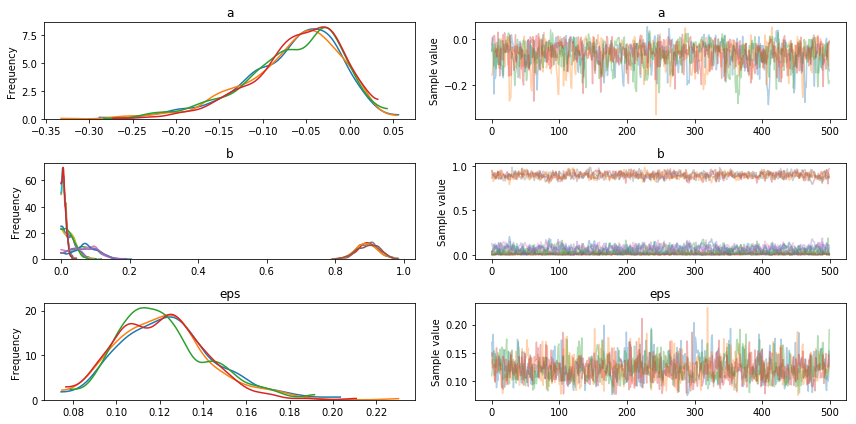

In [24]:
pm.traceplot(trace, varnames=['a', 'b', 'eps']);

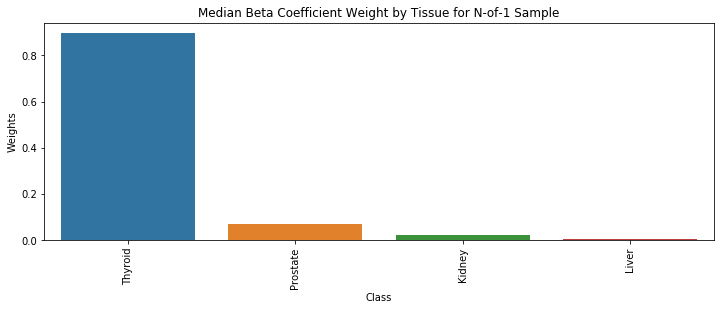

In [28]:
r.outlier.plot_weights(classes, trace)

# All Normals

In [29]:
sample = tumor.loc['TCGA-FY-A3I4-01']
print(f"Sample comes from tissue: {sample.tissue}")
# We'll pick a subset of normal tissue for model training
test = normal#[normal.tissue.isin(['Thyroid', 'Prostate', 'Kidney', 'Liver'])]
training_genes = r.outlier.select_k_best_genes(test, genes, 'tissue', 50)
classes = sorted(test.tissue.unique())
ncats = len(classes)
print(f'{ncats} background datasets and {len(training_genes)} genes')

Sample comes from tissue: Thyroid
20 background datasets and 50 genes


In [30]:
with pm.Model() as model:
    # Linear model priors
    a =  pm.Normal('a', mu=0, sd=10)
    b = pm.Dirichlet('b', a=np.ones(ncats))
    # Model error
    eps = pm.InverseGamma('eps', 2.1, 1)
    
    # Linear model declaration
    for gene in tqdm(training_genes):
        mu = a
        for i, dataset in enumerate(classes):
            cat_mu, cat_sd = st.norm.fit(test[test.tissue == dataset][gene])
            # Standard deviation can't be initialized to 0, so set to 0.1
            cat_sd = 0.1 if cat_sd == 0 else cat_sd
            name = f'{gene}-{dataset}'
            y = pm.Normal(name, cat_mu, cat_sd)
            mu += b[i] * y
        
        # Embed mu in laplacian distribution
        pm.Laplace(gene, mu=mu, b=eps, observed=sample[gene])

INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.thean

INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (the

INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.thean

INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (the

INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.thean

INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (the

INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.thean

INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (the

INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.thean

INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (the

INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.thean

INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (the

INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '3655' (I am process '4322')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.thean

In [31]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PSMB11-Uterus, PSMB11-Thyroid, PSMB11-Thymus, PSMB11-Stomach, PSMB11-Soft_tissue, PSMB11-Skin, PSMB11-Prostate, PSMB11-Pancreas, PSMB11-Lung, PSMB11-Liver, PSMB11-Kidney, PSMB11-Head, PSMB11-Esophagus, PSMB11-Colon, PSMB11-Cervix, PSMB11-Breast, PSMB11-Brain, PSMB11-Bladder, PSMB11-Bile, PSMB11-Adrenal, GBP7-Uterus, GBP7-Thyroid, GBP7-Thymus, GBP7-Stomach, GBP7-Soft_tissue, GBP7-Skin, GBP7-Prostate, GBP7-Pancreas, GBP7-Lung, GBP7-Liver, GBP7-Kidney, GBP7-Head, GBP7-Esophagus, GBP7-Colon, GBP7-Cervix, GBP7-Breast, GBP7-Brain, GBP7-Bladder, GBP7-Bile, GBP7-Adrenal, SLC22A9-Uterus, SLC22A9-Thyroid, SLC22A9-Thymus, SLC22A9-Stomach, SLC22A9-Soft_tissue, SLC22A9-Skin, SLC22A9-Prostate, SLC22A9-Pancreas, SLC22A9-Lung, SLC22A9-Liver, SLC22A9-Kidney, SLC22A9-Head, SLC22A9-Esophagus, SLC22A9-Colon, SLC22A9-Cervix, SLC22A9-Breast, SLC22A9-Brain, SLC22A9-Bladder, SLC22A9-Bi

Sampling 4 chains: 100%|██████████| 4000/4000 [1:41:18<00:00,  5.20s/draws]
The number of effective samples is smaller than 25% for some parameters.


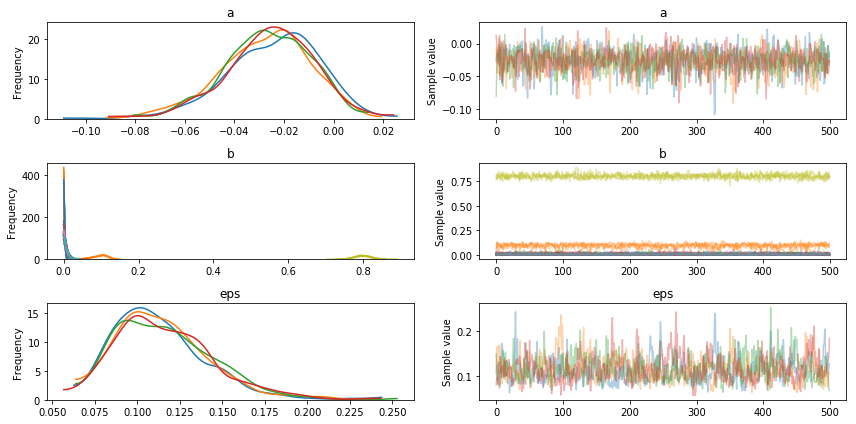

In [32]:
pm.traceplot(trace, varnames=['a', 'b', 'eps']);

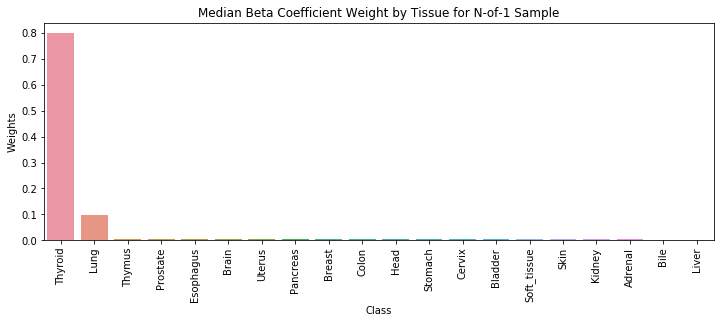

In [33]:
r.outlier.plot_weights(classes, trace)

In [34]:
ppc = pm.sample_ppc(trace, model=model)

100%|██████████| 500/500 [05:53<00:00,  1.54it/s]


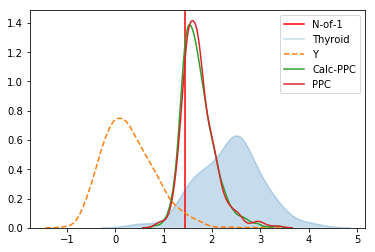

In [49]:
gene = 'SFTPC'
plt.axvline(sample[gene], c='r', label='N-of-1')
sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid')
sns.kdeplot(trace[f'{gene}-Thyroid'], ls='--', label='Y')
sns.kdeplot(calc_ppc(trace, gene), label='Calc-PPC')
sns.kdeplot(ppc[gene], label='PPC')

In [48]:
def calc_ppc(trace, gene):
    y_gene = [x for x in trace.varnames if x.startswith(gene)]
    b = trace['a']
    for i, y_name in enumerate(y_gene):
        b += trace['b'][:,i] * trace[y_name]
    return np.random.laplace(loc=b, scale=trace['eps'])

# Drug Run with 2 Highest Weighted Tissues

In [59]:
thyroid_lung = normal[normal.tissue.isin(['Thyroid', 'Lung'])]
classes = sorted(thyroid_lung.tissue.unique())
#training_genes = r.outlier.select_k_best_genes(thyroid_lung, genes, 'tissue')

In [65]:
drug_model, drug_trace = run_model(sample, thyroid_lung, drug_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Thyroid, PARP1-Lung, AURKC-Thyroid, AURKC-Lung, AURKB-Thyroid, AURKB-Lung, AURKA-Thyroid, AURKA-Lung, MS4A1-Thyroid, MS4A1-Lung, BTK-Thyroid, BTK-Lung, HSP90B1-Thyroid, HSP90B1-Lung, HSP90AB3P-Thyroid, HSP90AB3P-Lung, HSP90AB1-Thyroid, HSP90AB1-Lung, HSP90AA1-Thyroid, HSP90AA1-Lung, MDM2-Thyroid, MDM2-Lung, BCL6-Thyroid, BCL6-Lung, BCL2-Thyroid, BCL2-Lung, SMO-Thyroid, SMO-Lung, GLI1-Thyroid, GLI1-Lung, PTCH1-Thyroid, PTCH1-Lung, MAP2K2-Thyroid, MAP2K2-Lung, MAP2K1-Thyroid, MAP2K1-Lung, ARAF-Thyroid, ARAF-Lung, RAF1-Thyroid, RAF1-Lung, BRAF-Thyroid, BRAF-Lung, HRAS-Thyroid, HRAS-Lung, KRAS-Thyroid, KRAS-Lung, NRAS-Thyroid, NRAS-Lung, DEPTOR-Thyroid, DEPTOR-Lung, MLST8-Thyroid, MLST8-Lung, RPTOR-Thyroid, RPTOR-Lung, MTOR-Thyroid, MTOR-Lung, TSC2-Thyroid, TSC2-Lung, TSC1-Thyroid, TSC1-Lung, AKT3-Thyroid, AKT3-Lung, AKT1-Thyroid, AKT1-Lung, PIK3C3-Thyroid, PIK3C3-Lung, PIK3C2G-Thyroid, PIK3C2G-Lung, PIK3C2B-Thyroid, PIK3C2B-Lung, PIK

## Traceplot

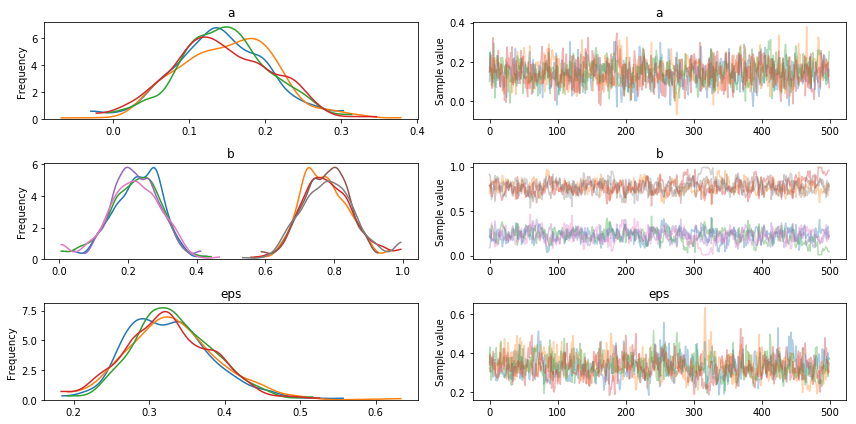

In [66]:
pm.traceplot(drug_trace, varnames=['a', 'b', 'eps']);

## Weight Plot

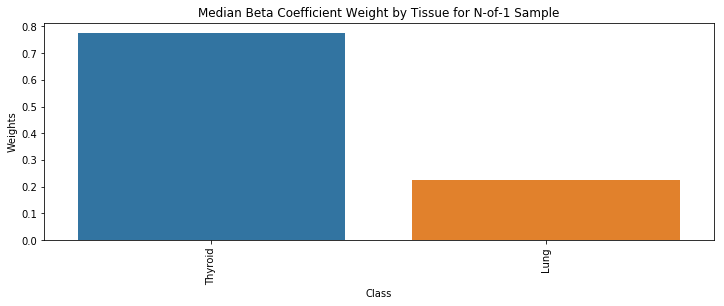

In [67]:
r.outlier.plot_weights(classes, drug_trace)

## PPC

In [68]:
drug_ppc = pm.sample_ppc(drug_trace, model=drug_model)

100%|██████████| 500/500 [01:39<00:00,  5.83it/s]


In [69]:
drug_ppc.keys()

dict_keys(['JAK1', 'JAK2', 'JAK3', 'STAT1', 'STAT2', 'STAT3', 'STAT5A', 'STAT5B', 'IL6', 'IL6R', 'EGFR', 'ERBB2', 'ERBB3', 'ALK', 'MET', 'ROS1', 'FLT1', 'FLT4', 'PDGFRA', 'PDGFRB', 'FGFR1', 'FGFR2', 'FGFR3', 'FGFR4', 'NTRK1', 'NTRK2', 'NTRK3', 'FLT3', 'KDR', 'KIT', 'CSF1R', 'TEK', 'CDK4', 'CDK6', 'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CDK2', 'PIK3CA', 'PIK3CB', 'PIK3CG', 'PIK3CD', 'PIK3R1', 'PIK3R2', 'PIK3R3', 'PIK3R4', 'PIK3R5', 'PIK3R6', 'PIK3C2A', 'PIK3C2B', 'PIK3C2G', 'PIK3C3', 'AKT1', 'AKT3', 'TSC1', 'TSC2', 'MTOR', 'RPTOR', 'MLST8', 'DEPTOR', 'NRAS', 'KRAS', 'HRAS', 'BRAF', 'RAF1', 'ARAF', 'MAP2K1', 'MAP2K2', 'PTCH1', 'GLI1', 'SMO', 'BCL2', 'BCL6', 'MDM2', 'HSP90AA1', 'HSP90AB1', 'HSP90AB3P', 'HSP90B1', 'BTK', 'MS4A1', 'AURKA', 'AURKB', 'AURKC', 'PARP1'])

### Example Gene

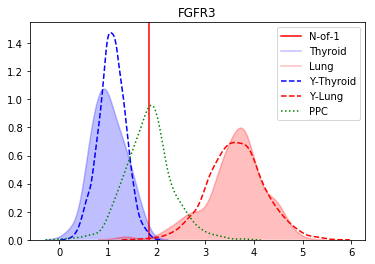

In [101]:
gene = 'FGFR3'
plt.axvline(sample[gene], c='r', label='N-of-1')
sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', c='b')
sns.kdeplot(normal[normal.tissue == 'Lung'][gene], shade=True, alpha=0.25, label='Lung', c='r')
sns.kdeplot(drug_trace[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', c='b')
sns.kdeplot(drug_trace[f'{gene}-Lung'], ls='--', label='Y-Lung', c='r')
#sns.kdeplot(calc_ppc(drug_trace, gene), label='Calc-PPC')
sns.kdeplot(drug_ppc[gene], label='PPC', ls=':', c='g')
plt.title(gene);

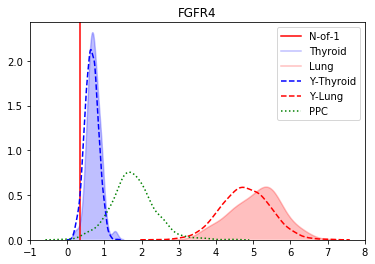

In [102]:
gene = 'FGFR4'
plt.axvline(sample[gene], c='r', label='N-of-1')
sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', c='b')
sns.kdeplot(normal[normal.tissue == 'Lung'][gene], shade=True, alpha=0.25, label='Lung', c='r')
sns.kdeplot(drug_trace[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', c='b')
sns.kdeplot(drug_trace[f'{gene}-Lung'], ls='--', label='Y-Lung', c='r')
#sns.kdeplot(calc_ppc(drug_trace, gene), label='Calc-PPC')
sns.kdeplot(drug_ppc[gene], label='PPC', ls=':', c='g')
plt.title(gene);

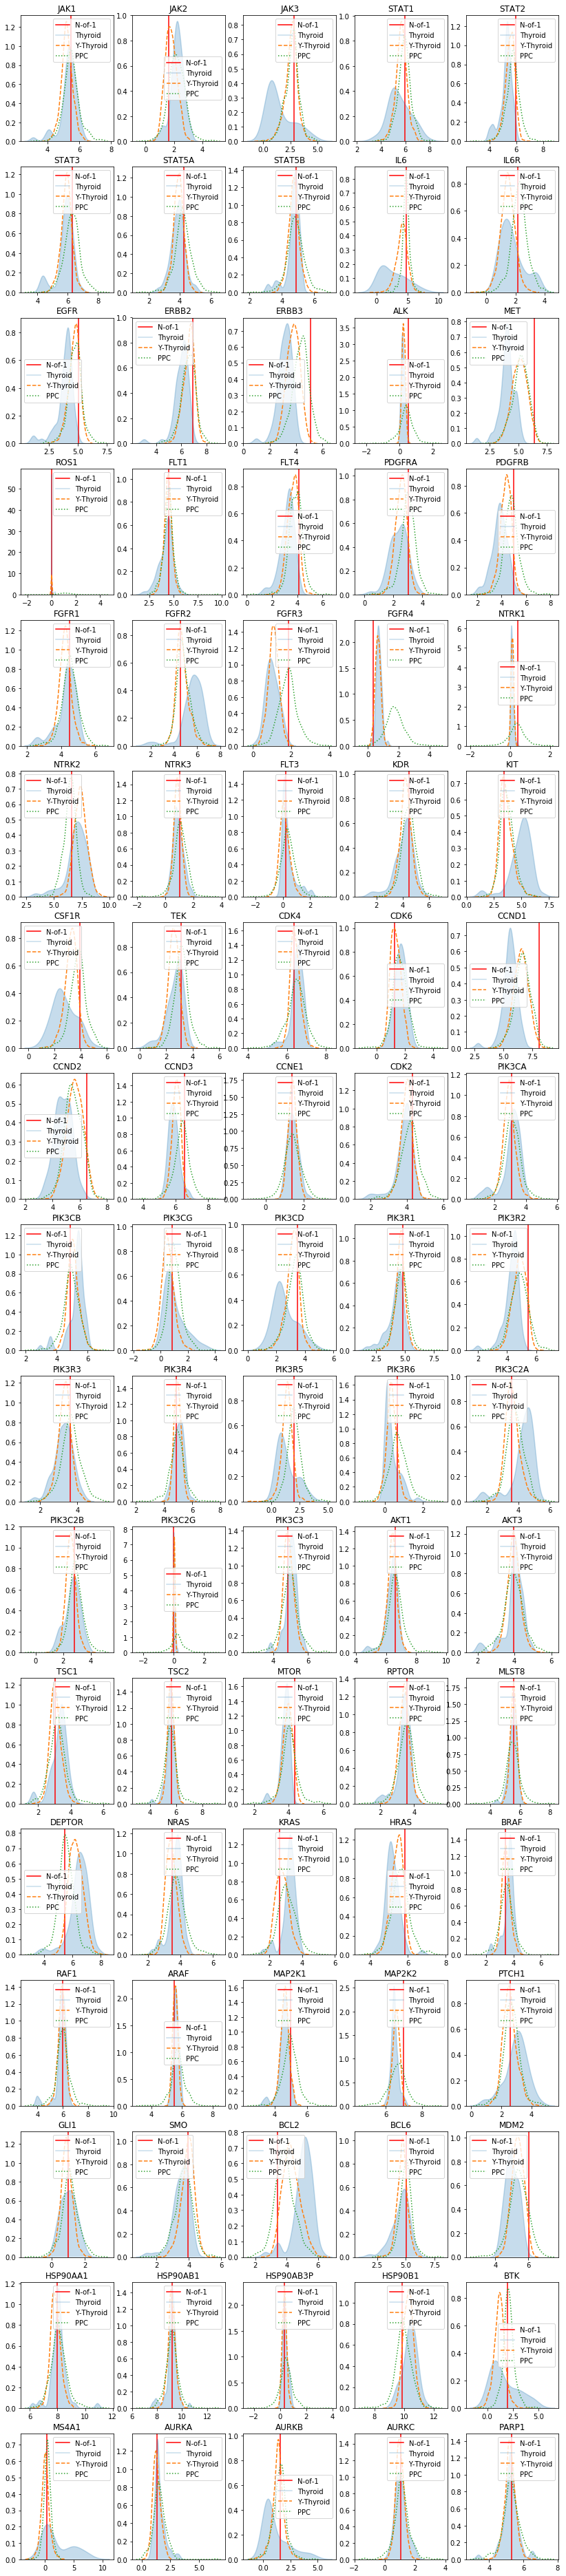

In [86]:
f, ax = plt.subplots(17, 5, figsize=(14, 4*17))
ax = ax.flatten()
for i, gene in enumerate(drug_genes):
    ax[i].axvline(sample[gene], c='r', label='N-of-1')
    sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', ax=ax[i])
    sns.kdeplot(drug_trace[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', ax=ax[i])
    sns.kdeplot(drug_ppc[gene], label='PPC', ls=':', ax=ax[i])
    ax[i].set_title(gene)

# Try "Short Run" to Choose Tissues

In [103]:
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', 50)

In [108]:
short_model, short_trace = run_model(sample, normal, training_genes, draws=50)

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PSMB11-Uterus, PSMB11-Thyroid, PSMB11-Thymus, PSMB11-Stomach, PSMB11-Soft_tissue, PSMB11-Skin, PSMB11-Prostate, PSMB11-Pancreas, PSMB11-Lung, PSMB11-Liver, PSMB11-Kidney, PSMB11-Head, PSMB11-Esophagus, PSMB11-Colon, PSMB11-Cervix, PSMB11-Breast, PSMB11-Brain, PSMB11-Bladder, PSMB11-Bile, PSMB11-Adrenal, GBP7-Uterus, GBP7-Thyroid, GBP7-Thymus, GBP7-Stomach, GBP7-Soft_tissue, GBP7-Skin, GBP7-Prostate, GBP7-Pancreas, GBP7-Lung, GBP7-Liver, GBP7-Kidney, GBP7-Head, GBP7-Esophagus, GBP7-Colon, GBP7-Cervix, GBP7-Breast, GBP7-Brain, GBP7-Bladder, GBP7-Bile, GBP7-Adrenal, SLC22A9-Uterus, SLC22A9-Thyroid, SLC22A9-Thymus, SLC22A9-Stomach, SLC22A9-Soft_tissue, SLC22A9-Skin, SLC22A9-Prostate, SLC22A9-Pancreas, SLC22A9-Lung, SLC22A9-Liver, SLC22A9-Kidney, SLC22A9-Head, SLC22A9-Esophagus, SLC22A9-Colon, SLC22A9-Cervix, SLC22A9-Breast, SLC22A9-Brain, SLC22A9-Bladder, SLC22A9-Bile, SLC22A9-Adrenal, UROC1-Uterus, UROC1-Thyroid, UROC1-Thymus, UROC1-Stomac

Sampling 4 chains: 100%|██████████| 2200/2200 [1:02:51<00:00,  4.36s/draws]


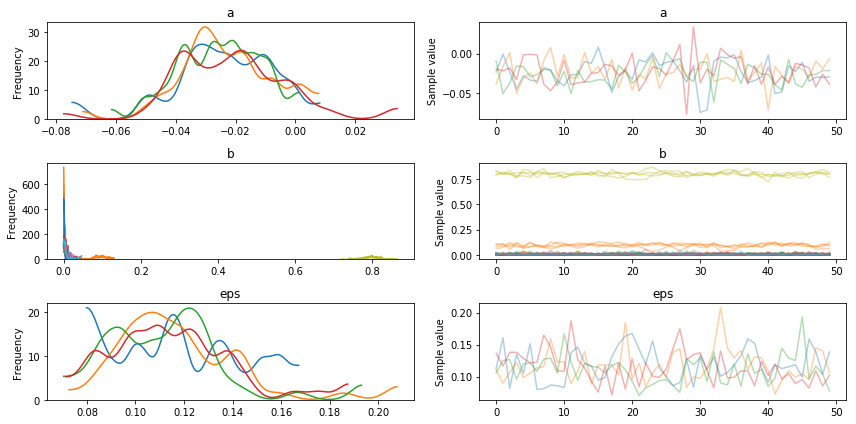

In [112]:
pm.traceplot(short_trace, varnames=['a', 'b', 'eps']);

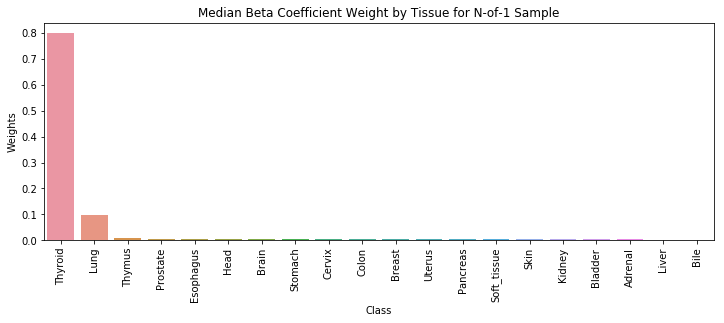

In [114]:
r.outlier.plot_weights(normal.tissue.unique(), short_trace)

## Shorten Run with ADVI Initialization

### ADVI + Adapt_diag

In [115]:
advi_model, advi_trace = run_model(sample, normal, training_genes, draws=50, init='advi+adapt_diag')

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Average Loss = 2.176e+05:   3%|▎         | 5660/200000 [03:20<1:52:54, 28.69it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 6,056.1:   7%|▋         | 14809/200000 [08:43<1:45:49, 29.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 133.4:  12%|█▏        | 24685/200000 [14:30<1:40:38, 29.03it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order

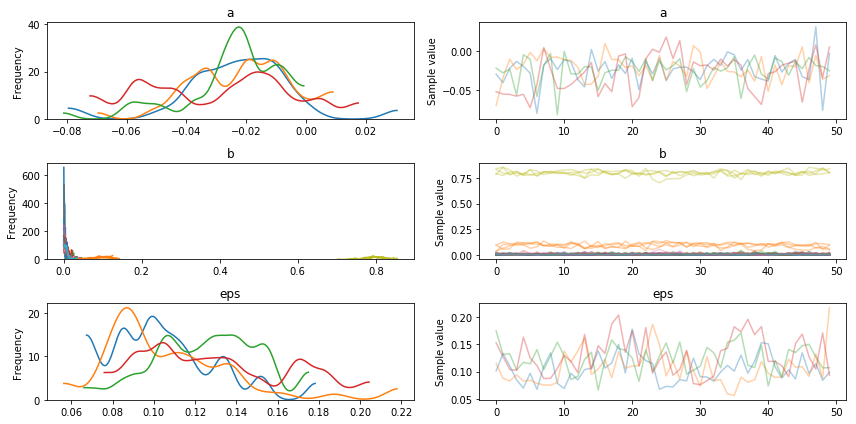

In [117]:
pm.traceplot(advi_trace, varnames=['a', 'b', 'eps']);

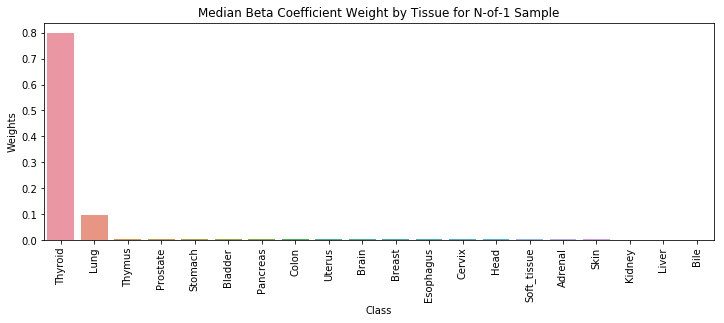

In [118]:
r.outlier.plot_weights(normal.tissue.unique(), advi_trace)

### ADVI

In [119]:
advi_model, advi_trace = run_model(sample, normal, training_genes, draws=50, init='advi')

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Average Loss = 1.6428e+05:   3%|▎         | 6419/200000 [03:32<2:01:01, 26.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 4,236.7:   8%|▊         | 15687/200000 [08:52<1:52:57, 27.20it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 153.01:  12%|█▏        | 24170/200000 [13:57<1:43:30, 28.31it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order

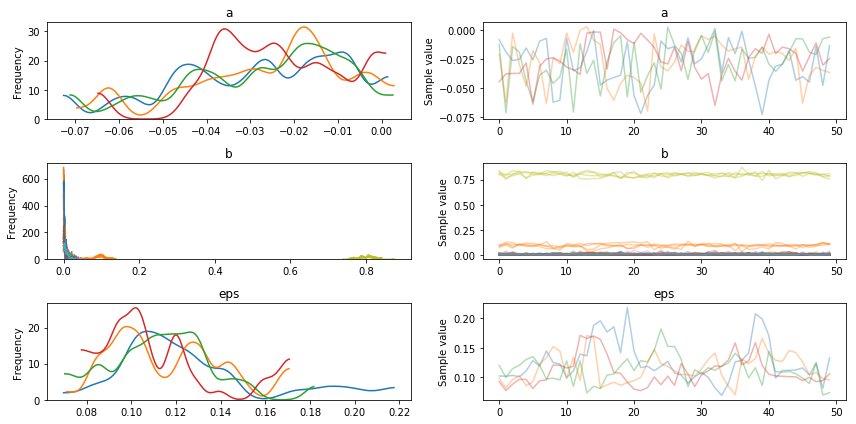

In [121]:
pm.traceplot(advi_trace, varnames=['a', 'b', 'eps']);

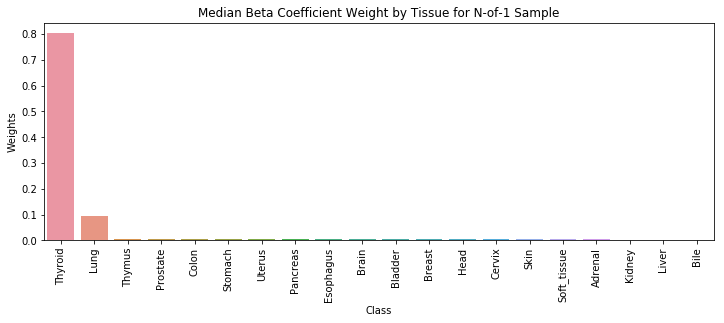

In [122]:
r.outlier.plot_weights(normal.tissue.unique(), advi_trace)

# GTEx Run

In [5]:
training_genes = r.outlier.select_k_best_genes(gtex, genes, 'tissue', 50)

In [6]:
gtex_model, gtex_trace = run_model(sample, gtex, training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [TRPC5OS-Whole, TRPC5OS-Vagina, TRPC5OS-Uterus, TRPC5OS-Thyroid, TRPC5OS-Testis, TRPC5OS-Stomach, TRPC5OS-Spleen, TRPC5OS-Small_intestine, TRPC5OS-Skin, TRPC5OS-Prostate, TRPC5OS-Pituitary, TRPC5OS-Pancreas, TRPC5OS-Ovary, TRPC5OS-Nerve, TRPC5OS-Muscle, TRPC5OS-Minor, TRPC5OS-Lung, TRPC5OS-Liver, TRPC5OS-Kidney, TRPC5OS-Heart, TRPC5OS-Fallopian, TRPC5OS-Esophagus, TRPC5OS-Colon, TRPC5OS-Cervix, TRPC5OS-Cells, TRPC5OS-Breast, TRPC5OS-Brain, TRPC5OS-Bladder, TRPC5OS-Artery, TRPC5OS-Adrenal, TRPC5OS-Adipose, TFDP3-Whole, TFDP3-Vagina, TFDP3-Uterus, TFDP3-Thyroid, TFDP3-Testis, TFDP3-Stomach, TFDP3-Spleen, TFDP3-Small_intestine, TFDP3-Skin, TFDP3-Prostate, TFDP3-Pituitary, TFDP3-Pancreas, TFDP3-Ovary, TFDP3-Nerve, TFDP3-Muscle, TFDP3-Minor, TFDP3-Lung, TFDP3-Liver, TFDP3-Kidney, TFDP3-Heart, TFDP3-Fallopian, TFDP3-Esophagus, TFDP3-Colon, TFDP3-Cervix, TFDP3-Cells, TFDP3-Breast, TFDP3-Brain, TFDP3-Bladder, TFDP3-Artery, TFDP3-Adrenal, TFDP3-A

Sampling 4 chains: 100%|██████████| 4000/4000 [4:45:29<00:00, 15.84s/draws]  


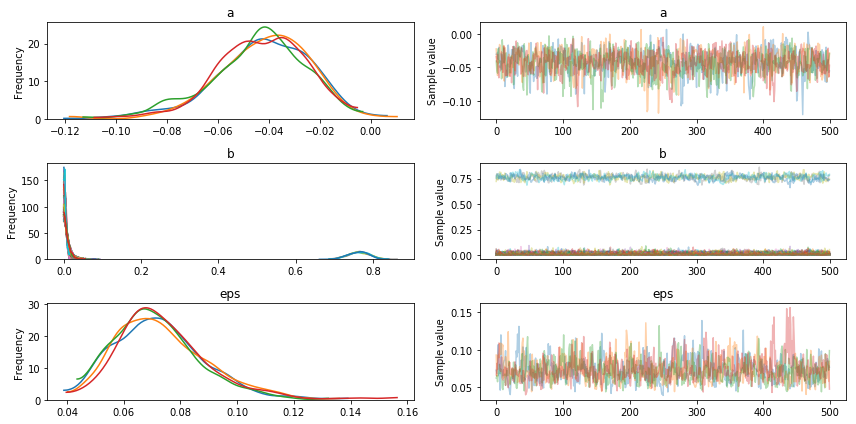

In [7]:
pm.traceplot(gtex_trace, varnames=['a', 'b', 'eps']);

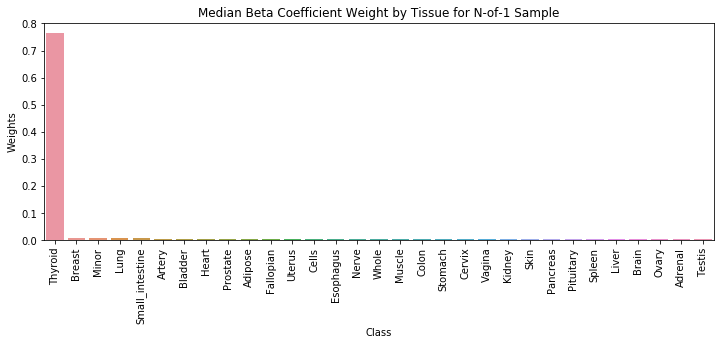

In [8]:
r.outlier.plot_weights(gtex.tissue.unique(), gtex_trace)

In [11]:
gtex_ppc = pm.sample_ppc(trace=gtex_trace, model=gtex_model)

100%|██████████| 500/500 [08:49<00:00,  1.04it/s]


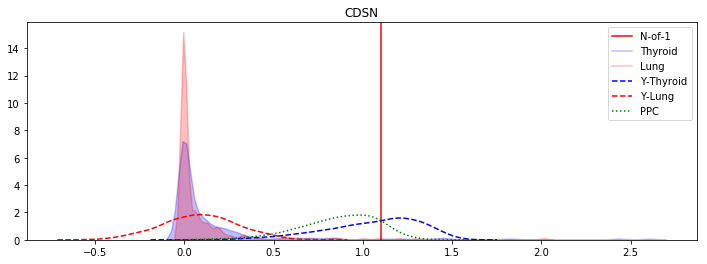

In [13]:
gene = 'CDSN'
plt.figure(figsize=(12, 4))
plt.axvline(sample[gene], c='r', label='N-of-1')
sns.kdeplot(gtex[gtex.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', c='b')
sns.kdeplot(gtex[gtex.tissue == 'Lung'][gene], shade=True, alpha=0.25, label='Lung', c='r')
sns.kdeplot(gtex_trace[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', c='b')
sns.kdeplot(gtex_trace[f'{gene}-Lung'], ls='--', label='Y-Lung', c='r')
sns.kdeplot(gtex_ppc[gene], label='PPC', ls=':', c='g')
plt.title(gene);

Massive shift in Y-thyroid which we want to avoid by using smaller D

# GTEx Drug Run

## Select Tissues via Pairwise Ranks

In [6]:
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

## Run Model

In [7]:
m, t = r.outlier.run_model(sample, training_group, drug_genes, 'tissue')


Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Thyroid, PARP1-Prostate, PARP1-Lung, PARP1-Breast, PARP1-Bladder, AURKC-Thyroid, AURKC-Prostate, AURKC-Lung, AURKC-Breast, AURKC-Bladder, AURKB-Thyroid, AURKB-Prostate, AURKB-Lung, AURKB-Breast, AURKB-Bladder, AURKA-Thyroid, AURKA-Prostate, AURKA-Lung, AURKA-Breast, AURKA-Bladder, MS4A1-Thyroid, MS4A1-Prostate, MS4A1-Lung, MS4A1-Breast, MS4A1-Bladder, BTK-Thyroid, BTK-Prostate, BTK-Lung, BTK-Breast, BTK-Bladder, HSP90B1-Thyroid, HSP90B1-Prostate, HSP90B1-Lung, HSP90B1-Breast, HSP90B1-Bladder, HSP90AB3P-Thyroid, HSP90AB3P-Prostate, HSP90AB3P-Lung, HSP90AB3P-Breast, HSP90AB3P-Bladder, HSP90AB1-Thyroid, HSP90AB1-Prostate, HSP90AB1-Lung, HSP90AB1-Breast, HSP90AB1-Bladder, HSP90AA1-Thyroid, HSP90AA1-Prostate, HSP90AA1-Lung, HSP90AA1-Breast, HSP90AA1-Bladder, MDM2-Thyroid, MDM2-Prostate, MDM2-Lung, MDM2-Breast, MDM2-Bladder, BCL6-Thyroid, BCL6-Prostate, BCL6-Lung, BCL6-Breast, BCL6-Bladder, BCL2-Thyroid, BCL2-Prostate, BCL2-Lung, BCL2-B

In [51]:
out = '/mnt/research_serializations/Dirichlet-Beta-Coefs/gtex-drug-genes.pkl'

In [9]:
r.outlier.pickle_model(out, m, t)

In [52]:
m, t = r.outlier.load_model(out)

## Traceplot

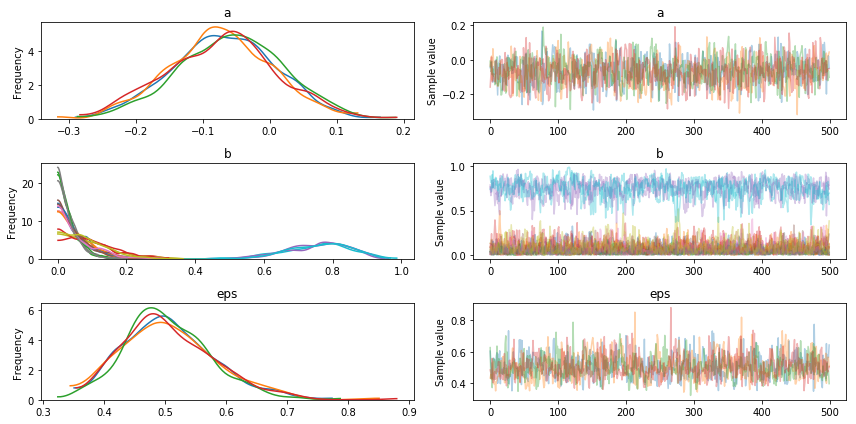

In [10]:
pm.traceplot(t, varnames=['a', 'b', 'eps']);

## Model Weights

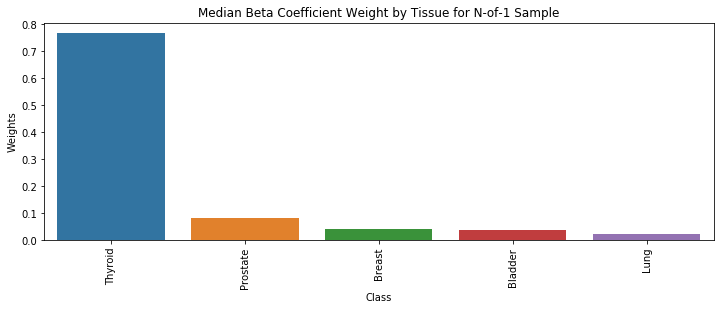

In [11]:
r.outlier.plot_weights(training_group.tissue.unique(), t)

## PPC

In [19]:
ppc = pm.sample_ppc(t, model=m)

100%|██████████| 500/500 [03:17<00:00,  3.10it/s]


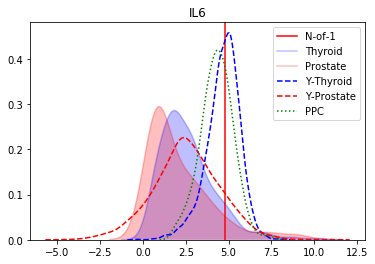

In [24]:
gene = 'IL6'
plt.axvline(sample[gene], c='r', label='N-of-1')
sns.kdeplot(gtex[gtex.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', c='b')
sns.kdeplot(gtex[gtex.tissue == 'Prostate'][gene], shade=True, alpha=0.25, label='Prostate', c='r')
sns.kdeplot(t[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', c='b')
sns.kdeplot(t[f'{gene}-Prostate'], ls='--', label='Y-Prostate', c='r')
sns.kdeplot(ppc[gene], label='PPC', ls=':', c='g')
plt.title(gene);

## Drug Plots

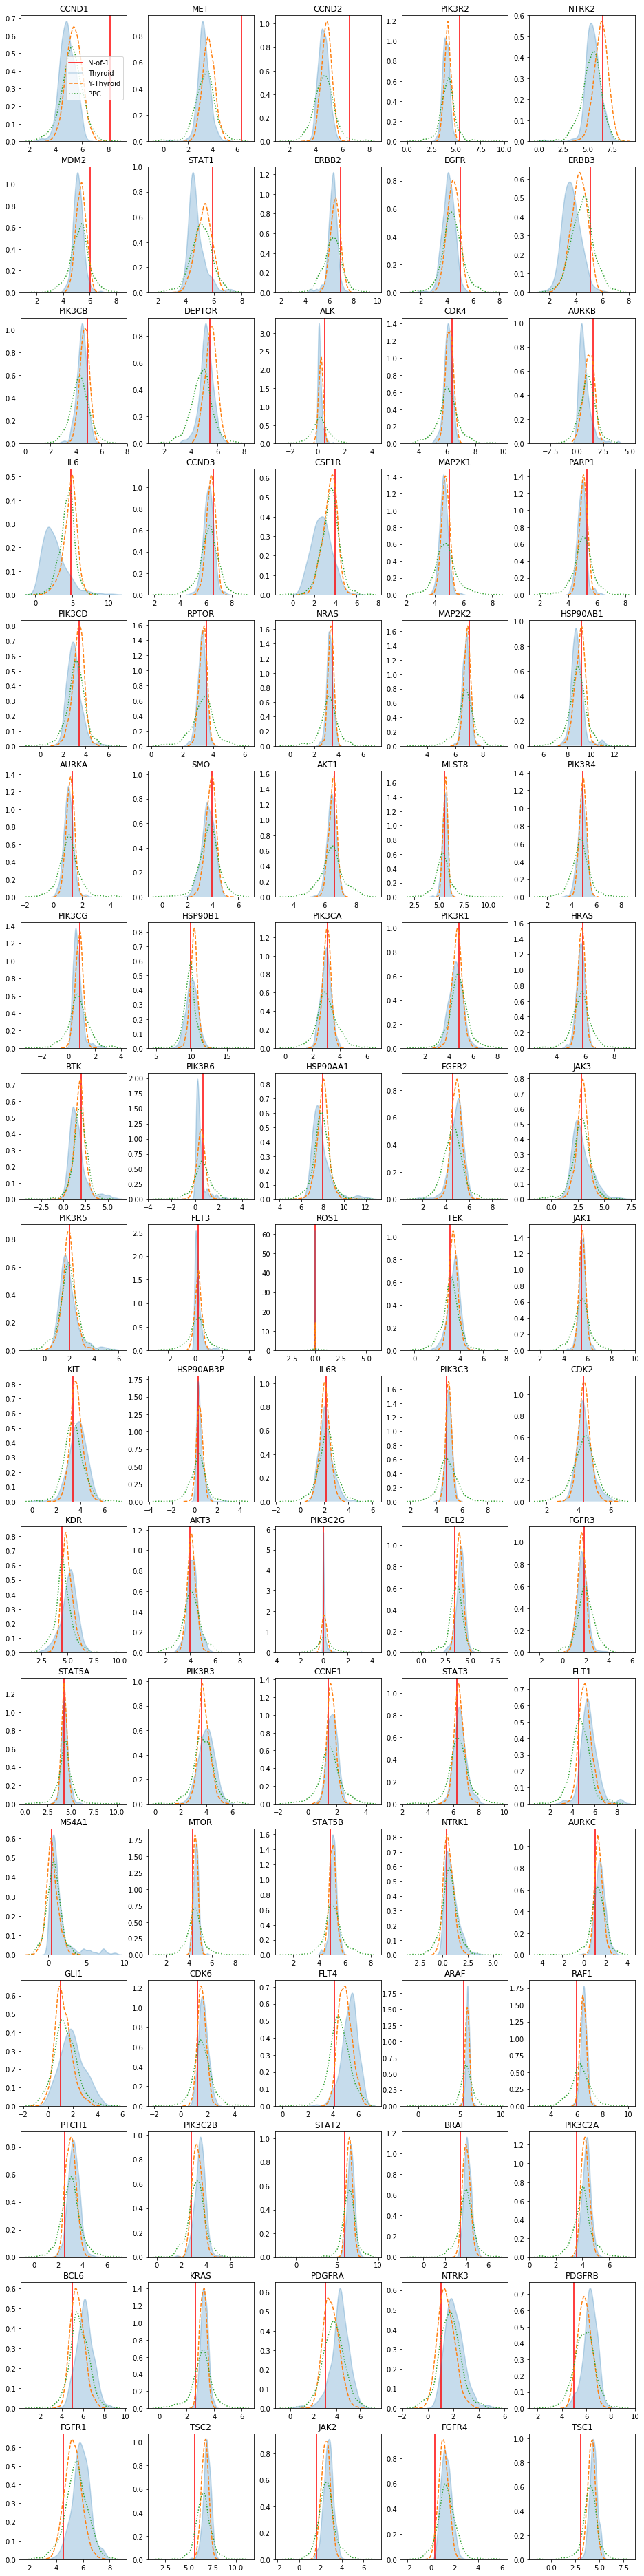

In [20]:
f, ax = plt.subplots(17, 5, figsize=(16, 4*17))
ax = ax.flatten()
for i, gene in enumerate(ppp0.index):
    ax[i].axvline(sample[gene], c='r', label='N-of-1')
    sns.kdeplot(gtex[gtex.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', ax=ax[i])
    sns.kdeplot(t[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', ax=ax[i])
    sns.kdeplot(ppc[gene], label='PPC', ls=':', ax=ax[i])
    ax[i].set_title(gene)
    if i != 0:
        ax[i].legend_.remove()

# GTEx Drug + SelectKBest Run

## Select tissues via pairwise ranks

In [4]:
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

In [5]:
training_genes = r.outlier.select_k_best_genes(training_group, genes, n=85)

## Run Model

In [6]:
m0, t0 = r.outlier.run_model(sample, training_group, training_genes + drug_genes, 'tissue')


Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Thyroid, PARP1-Prostate, PARP1-Lung, PARP1-Breast, PARP1-Bladder, AURKC-Thyroid, AURKC-Prostate, AURKC-Lung, AURKC-Breast, AURKC-Bladder, AURKB-Thyroid, AURKB-Prostate, AURKB-Lung, AURKB-Breast, AURKB-Bladder, AURKA-Thyroid, AURKA-Prostate, AURKA-Lung, AURKA-Breast, AURKA-Bladder, MS4A1-Thyroid, MS4A1-Prostate, MS4A1-Lung, MS4A1-Breast, MS4A1-Bladder, BTK-Thyroid, BTK-Prostate, BTK-Lung, BTK-Breast, BTK-Bladder, HSP90B1-Thyroid, HSP90B1-Prostate, HSP90B1-Lung, HSP90B1-Breast, HSP90B1-Bladder, HSP90AB3P-Thyroid, HSP90AB3P-Prostate, HSP90AB3P-Lung, HSP90AB3P-Breast, HSP90AB3P-Bladder, HSP90AB1-Thyroid, HSP90AB1-Prostate, HSP90AB1-Lung, HSP90AB1-Breast, HSP90AB1-Bladder, HSP90AA1-Thyroid, HSP90AA1-Prostate, HSP90AA1-Lung, HSP90AA1-Breast, HSP90AA1-Bladder, MDM2-Thyroid, MDM2-Prostate, MDM2-Lung, MDM2-Breast, MDM2-Bladder, BCL6-Thyroid, BCL6-Prostate, BCL6-Lung, BCL6-Breast, BCL6-Bladder, BCL2-Thyroid, BCL2-Prostate, BCL2-Lung, BCL2-B

Sampling 4 chains: 100%|██████████| 4000/4000 [42:30<00:00,  1.85s/draws] 


In [49]:
out = '/mnt/research_serializations/Dirichlet-Beta-Coefs/gtex-drug-and-85-selectKBest.pkl'

In [16]:
r.outlier.pickle_model(out, m0, t0)

In [50]:
m0, t0 = r.outlier.load_model(out)

## Traceplot

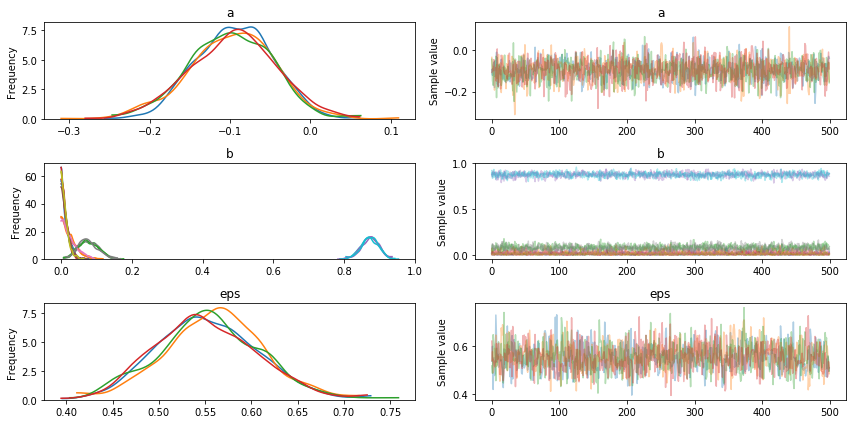

In [7]:
pm.traceplot(t0, varnames=['a', 'b', 'eps']);

## Model Weights

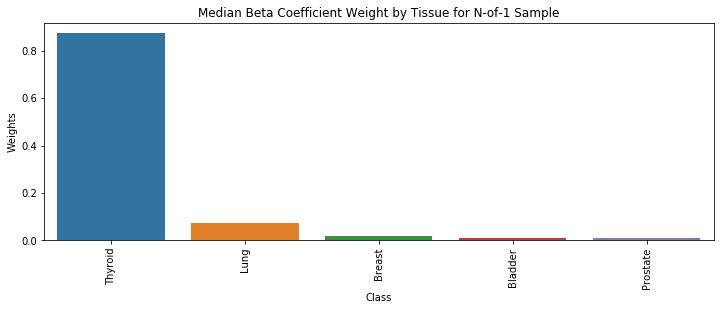

In [8]:
r.outlier.plot_weights(training_group.tissue.unique(), t0);

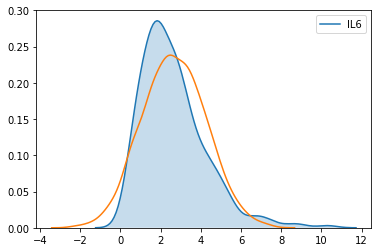

In [165]:
real = gtex[gtex.tissue == 'Thyroid']['IL6']
sns.kdeplot(real, shade=True)
mu, sd = st.norm.fit(real)
rvs = st.norm.rvs(mu, sd, size=2000)
sns.kdeplot(rvs)

## PPC

In [9]:
ppc0 = pm.sample_ppc(t0, model=m0)

100%|██████████| 500/500 [06:04<00:00,  1.54it/s]


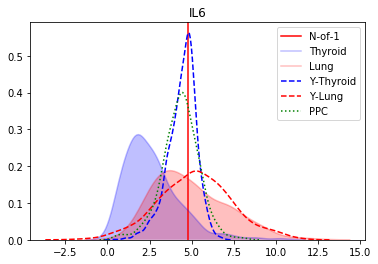

In [13]:
gene = 'IL6'
plt.axvline(sample[gene], c='r', label='N-of-1')
sns.kdeplot(gtex[gtex.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', c='b')
sns.kdeplot(gtex[gtex.tissue == 'Lung'][gene], shade=True, alpha=0.25, label='Lung', c='r')
sns.kdeplot(t0[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', c='b')
sns.kdeplot(t0[f'{gene}-Lung'], ls='--', label='Y-Lung', c='r')
sns.kdeplot(ppc0[gene], label='PPC', ls=':', c='g')
plt.title(gene);

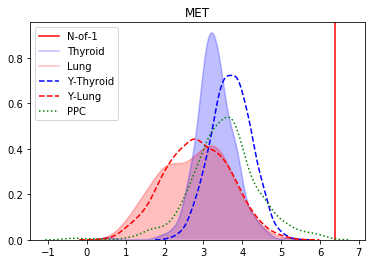

In [36]:
gene = 'MET'
plt.axvline(sample[gene], c='r', label='N-of-1')
sns.kdeplot(gtex[gtex.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', c='b')
sns.kdeplot(gtex[gtex.tissue == 'Lung'][gene], shade=True, alpha=0.25, label='Lung', c='r')
sns.kdeplot(t0[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', c='b')
sns.kdeplot(t0[f'{gene}-Lung'], ls='--', label='Y-Lung', c='r')
sns.kdeplot(ppc0[gene], label='PPC', ls=':', c='g')
plt.title(gene);

## PPP

In [22]:
y_gene = [x for x in t0.varnames if x.startswith(gene)]

In [23]:
ppc_calc0 = r.outlier.ppc(t0, drug_genes)

In [24]:
ppp0 = r.outlier.posterior_predictive_pvals(sample, ppc_calc0)

## Drug Plots

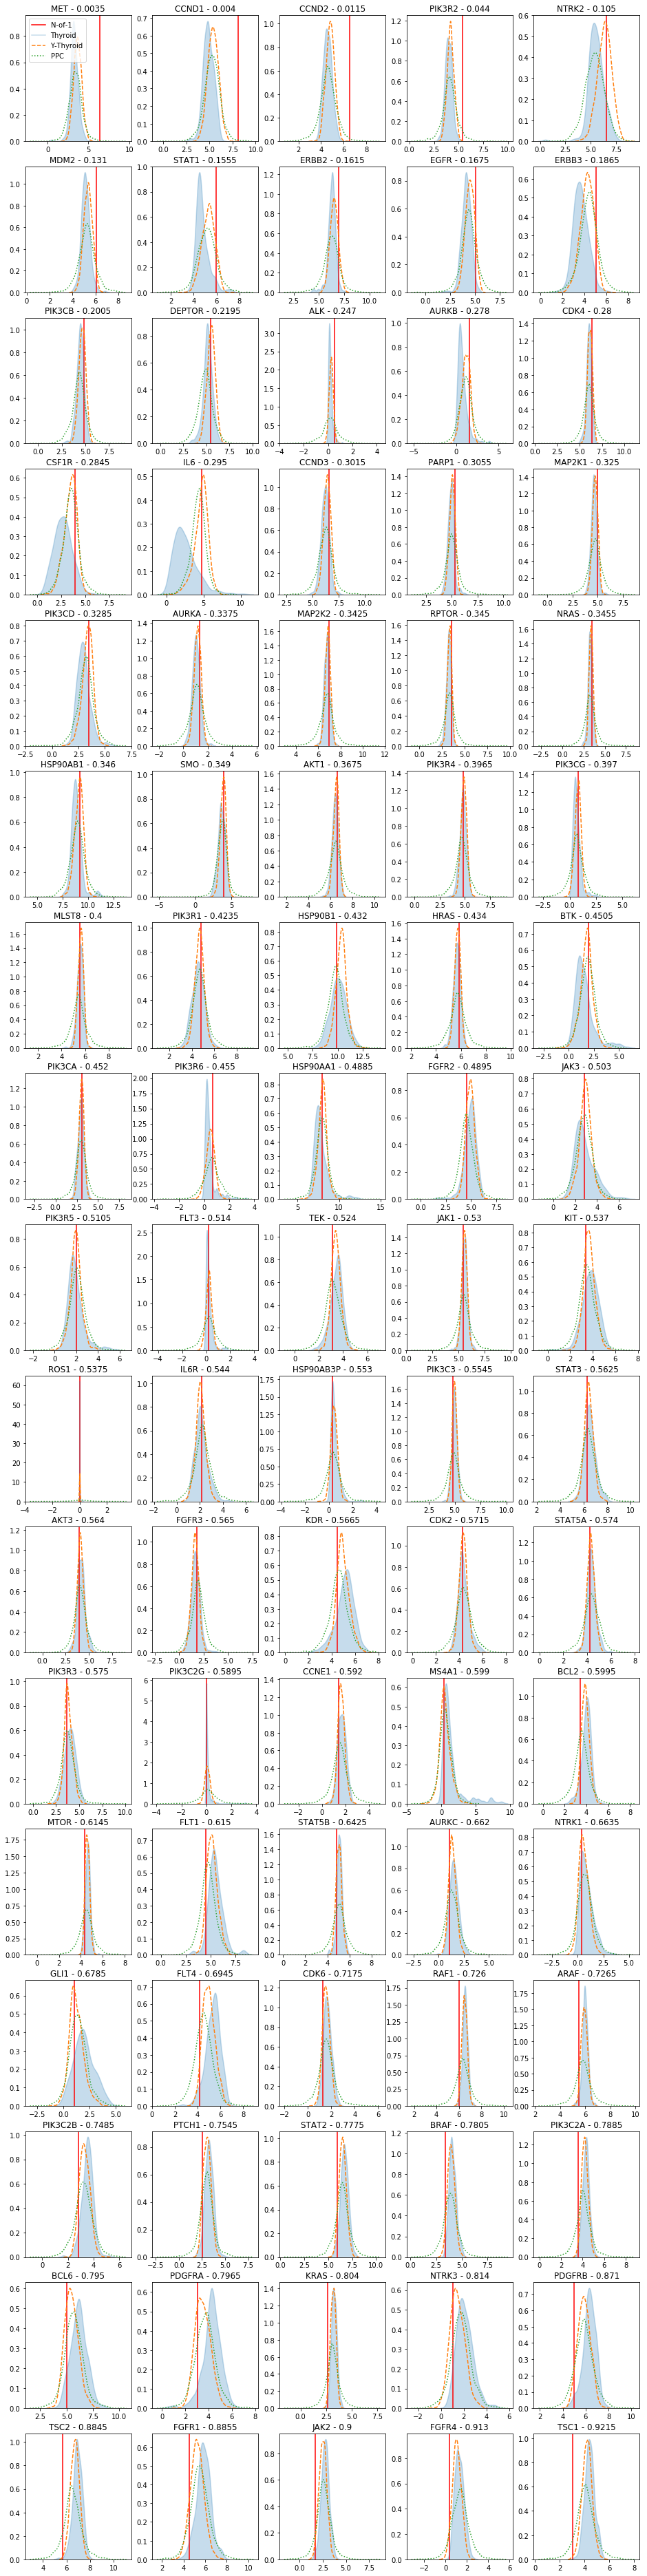

In [26]:
f, ax = plt.subplots(17, 5, figsize=(16, 4*17))
ax = ax.flatten()
for i, gene in enumerate(ppp0.index):
    ax[i].axvline(sample[gene], c='r', label='N-of-1')
    sns.kdeplot(gtex[gtex.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', ax=ax[i])
    sns.kdeplot(t0[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', ax=ax[i])
    sns.kdeplot(ppc_calc0[gene], label='PPC', ls=':', ax=ax[i])
    ax[i].set_title(f'{gene} - {ppp0[gene]}')
    if i != 0:
        ax[i].legend_.remove()

# Runtimes
- Is runtime determined mostly by n-genes or which genes?

## SelectKBest (85)

In [46]:
training_genes = r.outlier.select_k_best_genes(training_group, genes, n=85)

In [48]:
m2, t2 = r.outlier.run_model(sample, training_group, training_genes)


Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [RP11-616M22.2-Thyroid, RP11-616M22.2-Prostate, RP11-616M22.2-Lung, RP11-616M22.2-Breast, RP11-616M22.2-Bladder, AC068138.1-Thyroid, AC068138.1-Prostate, AC068138.1-Lung, AC068138.1-Breast, AC068138.1-Bladder, RP1-170O19.14-Thyroid, RP1-170O19.14-Prostate, RP1-170O19.14-Lung, RP1-170O19.14-Breast, RP1-170O19.14-Bladder, CTD-2314G24.2-Thyroid, CTD-2314G24.2-Prostate, CTD-2314G24.2-Lung, CTD-2314G24.2-Breast, CTD-2314G24.2-Bladder, RP13-895J2.3-Thyroid, RP13-895J2.3-Prostate, RP13-895J2.3-Lung, RP13-895J2.3-Breast, RP13-895J2.3-Bladder, NKX2-1-AS1-Thyroid, NKX2-1-AS1-Prostate, NKX2-1-AS1-Lung, NKX2-1-AS1-Breast, NKX2-1-AS1-Bladder, HOTTIP-Thyroid, HOTTIP-Prostate, HOTTIP-Lung, HOTTIP-Breast, HOTTIP-Bladder, FRMPD3-Thyroid, FRMPD3-Prostate, FRMPD3-Lung, FRMPD3-Breast, FRMPD3-Bladder, ISL1-Thyroid, ISL1-Prostate, ISL1-Lung, ISL1-Breast, ISL1-Bladder, ZMAT4-Thyroid, ZMAT4-Prostate, ZMAT4-Lung, ZMAT4-Breast, ZMAT4-Bladder, RP11-231P20.2-Thyroi

## Random (85)

In [44]:
rand_genes = list(np.random.choice(genes, 85, replace=False))

In [45]:
m3, t3 = r.outlier.run_model(sample, training_group, rand_genes)


Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CSTF3-Thyroid, CSTF3-Prostate, CSTF3-Lung, CSTF3-Breast, CSTF3-Bladder, ZSCAN29-Thyroid, ZSCAN29-Prostate, ZSCAN29-Lung, ZSCAN29-Breast, ZSCAN29-Bladder, LAMA5-Thyroid, LAMA5-Prostate, LAMA5-Lung, LAMA5-Breast, LAMA5-Bladder, SRBD1-Thyroid, SRBD1-Prostate, SRBD1-Lung, SRBD1-Breast, SRBD1-Bladder, DMXL2-Thyroid, DMXL2-Prostate, DMXL2-Lung, DMXL2-Breast, DMXL2-Bladder, PDE6B-Thyroid, PDE6B-Prostate, PDE6B-Lung, PDE6B-Breast, PDE6B-Bladder, TMEM72-Thyroid, TMEM72-Prostate, TMEM72-Lung, TMEM72-Breast, TMEM72-Bladder, EIF4E3-Thyroid, EIF4E3-Prostate, EIF4E3-Lung, EIF4E3-Breast, EIF4E3-Bladder, TMEM218-Thyroid, TMEM218-Prostate, TMEM218-Lung, TMEM218-Breast, TMEM218-Bladder, INAFM2-Thyroid, INAFM2-Prostate, INAFM2-Lung, INAFM2-Breast, INAFM2-Bladder, RALGAPA1-Thyroid, RALGAPA1-Prostate, RALGAPA1-Lung, RALGAPA1-Breast, RALGAPA1-Bladder, GTF2H2-Thyroid, GTF2H2-Prostate, GTF2H2-Lung, GTF2H2-Breast, GTF2H2-Bladder, RAET1E-AS1-Thyroid, RAET1E-AS1-

## Drug Genes (85)
- 10m for sample, 28m total

# PPP Comparisons

In [54]:
ppc_drugs = r.outlier.ppc(t, drug_genes)
ppc_drugs_skb = r.outlier.ppc(t0, drug_genes)

ppp_drugs = r.outlier.posterior_predictive_pvals(sample, ppc_drugs)
ppp_drugs_skb = r.outlier.posterior_predictive_pvals(sample, ppc_drugs_skb)

In [57]:
ppp = pd.DataFrame([ppp_drugs, ppp_drugs_skb]).T
ppp.columns = ['Drugs', 'Drugs+SKB']

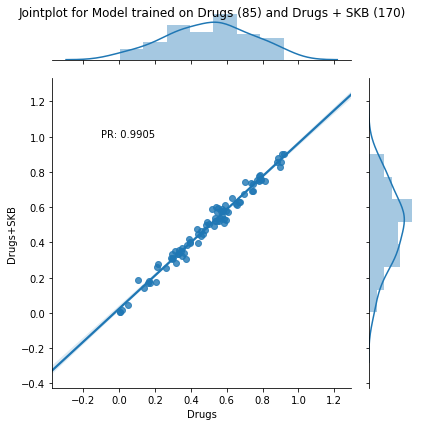

In [66]:
pr, pval = st.pearsonr(ppp.Drugs, ppp['Drugs+SKB'])
sns.jointplot(data=ppp, x='Drugs', y='Drugs+SKB', kind='reg')
plt.suptitle('Jointplot for Model trained on Drugs (85) and Drugs + SKB (170)')
plt.text(-0.1, 1.0, f'PR: {round(pr, 4)}')
plt.tight_layout()

# Compare to Shared Y Model

In [70]:
def shared_y_model(sample, df, training_genes, class_col='tissue'):
    classes = sorted(df[class_col].unique())
    df = df[[class_col] + training_genes]
    
    with pm.Model() as model:
        # Linear model priors
        a = pm.Normal('a', mu=0, sd=1)
        b = [1] if len(classes) == 1 else pm.Dirichlet('b', a=np.ones(len(classes)))
        # Model error
        eps = pm.InverseGamma('eps', 2.1, 1)

        # Define linear model
        ys = {}
        for gene in training_genes:
            for dataset in classes:
                name = f'{gene}-{dataset}'
                # Define mu and sigma that are shared between Ys (mu_{G,D} and sd_{G,D})
                y_mu = pm.Normal(f'{name}-mu', 0, 10)
                y_sigma = pm.InverseGamma(f'{name}-sd', 2.1, 1)
                y_obs = pm.Normal(f'{name}-Y-Obs', mu=y_mu, sd=y_sigma, observed=df[df.tissue == dataset][gene])
                ys[name] = pm.Normal(name, mu=y_mu, sd=y_sigma)

            # Linear model declaration
            mu = a
            for i, dataset in enumerate(classes):
                mu += b[i] * ys[f'{gene}-{dataset}']
            
            # Embed mu in laplacian
            pm.Laplace(gene, mu=mu, b=eps, observed=sample[gene])

        trace = pm.sample()
    return model, trace

In [71]:
m4, t4 = shared_y_model(sample, training_group, drug_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Thyroid, PARP1-Thyroid-sd, PARP1-Thyroid-mu, PARP1-Prostate, PARP1-Prostate-sd, PARP1-Prostate-mu, PARP1-Lung, PARP1-Lung-sd, PARP1-Lung-mu, PARP1-Breast, PARP1-Breast-sd, PARP1-Breast-mu, PARP1-Bladder, PARP1-Bladder-sd, PARP1-Bladder-mu, AURKC-Thyroid, AURKC-Thyroid-sd, AURKC-Thyroid-mu, AURKC-Prostate, AURKC-Prostate-sd, AURKC-Prostate-mu, AURKC-Lung, AURKC-Lung-sd, AURKC-Lung-mu, AURKC-Breast, AURKC-Breast-sd, AURKC-Breast-mu, AURKC-Bladder, AURKC-Bladder-sd, AURKC-Bladder-mu, AURKB-Thyroid, AURKB-Thyroid-sd, AURKB-Thyroid-mu, AURKB-Prostate, AURKB-Prostate-sd, AURKB-Prostate-mu, AURKB-Lung, AURKB-Lung-sd, AURKB-Lung-mu, AURKB-Breast, AURKB-Breast-sd, AURKB-Breast-mu, AURKB-Bladder, AURKB-Bladder-sd, AURKB-Bladder-mu, AURKA-Thyroid, AURKA-Thyroid-sd, AURKA-Thyroid-mu, AURKA-Prostate, AURKA-Prostate-sd, AURKA-Prostate-mu, AURKA-Lung, AURKA-Lung-sd, AURK

Sampling 4 chains: 100%|██████████| 4000/4000 [3:01:52<00:00,  5.63s/draws]  
The acceptance probability does not match the target. It is 0.9165361962875466, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859551175351355, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8966532494864058, but should be close to 0.8. Try to increase the number of tuning steps.


In [72]:
out = '/mnt/research_serializations/Dirichlet-Beta-Coefs/gtex-drug-shared-y-model.pkl'

In [73]:
r.outlier.pickle_model(out, m4, t4)

## Traceplot

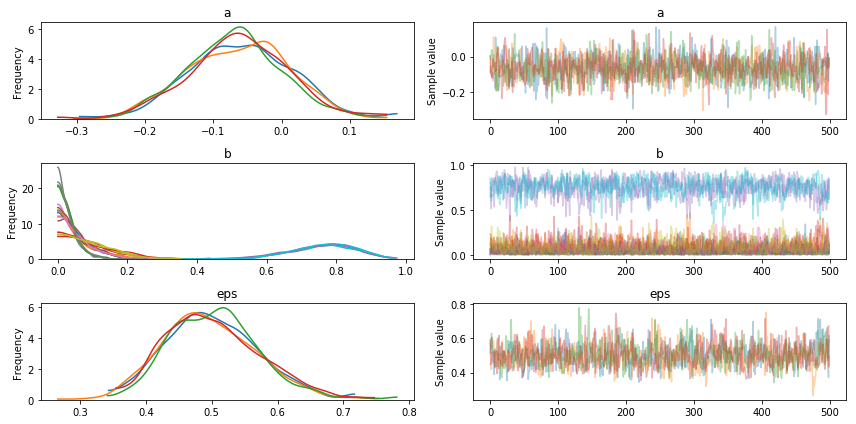

In [75]:
pm.traceplot(t4, varnames=['a', 'b', 'eps']);

## Model Weights

In [99]:
class_col = []
for tissue in training_group.tissue.unique():
    class_col.extend([tissue for x in range(2000)])

weights = pd.DataFrame({'Class': class_col,
           'Weights': np.array([t4['b'][:, x] for x in range(len(classes))]).ravel()})

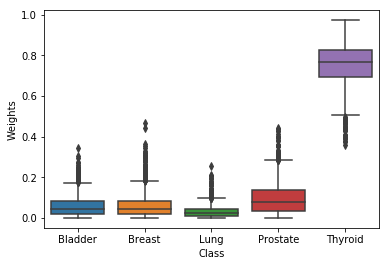

In [101]:
sns.boxplot(data=weights, x='Class', y='Weights');

## PPC

In [103]:
ppc4 = pm.sample_ppc(t4, model=m4)

100%|██████████| 500/500 [06:41<00:00,  1.45it/s]


In [117]:
def ppc(trace, classes, genes):
    """
    Posterior predictive check for a list of genes trained in the model

    Args:
        trace: PyMC3 trace
        genes: List of genes of interest

    Returns:

    """
    d = {}
    for gene in genes:
        d[gene] = _gene_ppc(trace, classes, gene)
    return d

def _gene_ppc(trace, classes, gene: str) -> np.array:
    """
    Calculate posterior predictive for a gene

    Args:
        trace: PyMC3 Trace
        gene: Gene of interest

    Returns:
        Random variates representing PPC of the gene
    """
    y_gene = [f'{gene}-{x}' for x in classes]
    b = trace['a']
    for i, y_name in enumerate(y_gene):
        b += trace['b'][:, i] * trace[y_name]
    return np.random.laplace(loc=b, scale=trace['eps'])

In [119]:
ppc4_calc = ppc(t4, classes, drug_genes)

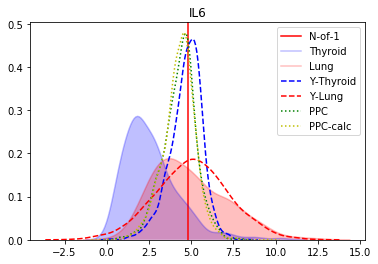

In [123]:
gene = 'IL6'
plt.axvline(sample[gene], c='r', label='N-of-1')
sns.kdeplot(gtex[gtex.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', c='b')
sns.kdeplot(gtex[gtex.tissue == 'Lung'][gene], shade=True, alpha=0.25, label='Lung', c='r')
sns.kdeplot(t4[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', c='b')
sns.kdeplot(t4[f'{gene}-Lung'], ls='--', label='Y-Lung', c='r')
sns.kdeplot(ppc4[gene], label='PPC', ls=':', c='g')
sns.kdeplot(ppc4_calc[gene], label='PPC-calc', ls=':', c='y')
plt.title(gene);

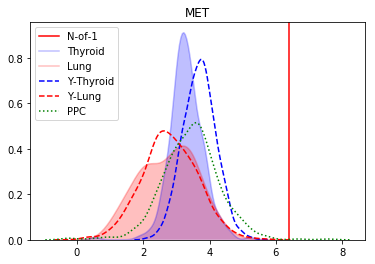

In [124]:
gene = 'MET'
plt.axvline(sample[gene], c='r', label='N-of-1')
sns.kdeplot(gtex[gtex.tissue == 'Thyroid'][gene], shade=True, alpha=0.25, label='Thyroid', c='b')
sns.kdeplot(gtex[gtex.tissue == 'Lung'][gene], shade=True, alpha=0.25, label='Lung', c='r')
sns.kdeplot(t4[f'{gene}-Thyroid'], ls='--', label='Y-Thyroid', c='b')
sns.kdeplot(t4[f'{gene}-Lung'], ls='--', label='Y-Lung', c='r')
sns.kdeplot(ppc4[gene], label='PPC', ls=':', c='g')
plt.title(gene);

## PPP

In [126]:
ppp4 = r.outlier.posterior_predictive_pvals(sample, ppc4_calc)

## Pearson Correlation to Prefit Model

In [128]:
ppp = pd.DataFrame([ppp_drugs, ppp4]).T
ppp.columns = ['Prefit', 'Shared-Y']

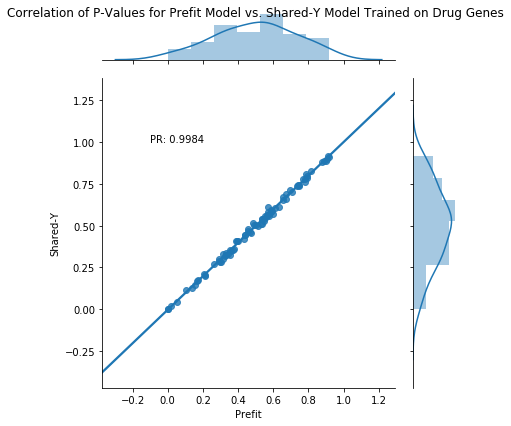

In [135]:
pr, pval = st.pearsonr(ppp.Prefit, ppp['Shared-Y'])
sns.jointplot(data=ppp, x='Prefit', y='Shared-Y', kind='reg')
plt.suptitle('Correlation of P-Values for Prefit Model vs. Shared-Y Model Trained on Drug Genes')
plt.text(-0.1, 1.0, f'PR: {round(pr, 4)}')
plt.tight_layout()

## WAIC Model Comparison

Can't do model comparison since models have different number of observed RVs

# Remove Thyroid and Rerun

In [136]:
ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

In [137]:
training_group = training_group[training_group.tissue != 'Thyroid']

## Run Model

In [140]:
m5, t5 = r.outlier.run_model(sample, training_group, drug_genes, 'tissue')


Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Prostate, PARP1-Lung, PARP1-Breast, PARP1-Bladder, AURKC-Prostate, AURKC-Lung, AURKC-Breast, AURKC-Bladder, AURKB-Prostate, AURKB-Lung, AURKB-Breast, AURKB-Bladder, AURKA-Prostate, AURKA-Lung, AURKA-Breast, AURKA-Bladder, MS4A1-Prostate, MS4A1-Lung, MS4A1-Breast, MS4A1-Bladder, BTK-Prostate, BTK-Lung, BTK-Breast, BTK-Bladder, HSP90B1-Prostate, HSP90B1-Lung, HSP90B1-Breast, HSP90B1-Bladder, HSP90AB3P-Prostate, HSP90AB3P-Lung, HSP90AB3P-Breast, HSP90AB3P-Bladder, HSP90AB1-Prostate, HSP90AB1-Lung, HSP90AB1-Breast, HSP90AB1-Bladder, HSP90AA1-Prostate, HSP90AA1-Lung, HSP90AA1-Breast, HSP90AA1-Bladder, MDM2-Prostate, MDM2-Lung, MDM2-Breast, MDM2-Bladder, BCL6-Prostate, BCL6-Lung, BCL6-Breast, BCL6-Bladder, BCL2-Prostate, BCL2-Lung, BCL2-Breast, BCL2-Bladder, SMO-Prostate, SMO-Lung, SMO-Breast, SMO-Bladder, GLI1-Prostate, GLI1-Lung, GLI1-Breast, GLI1-Bladder, PTCH1-Prostate, PTCH1-Lung, PTCH1-Breast, PTCH1-Bladder, MAP2K2-Prostate, MAP2K

## Traceplot

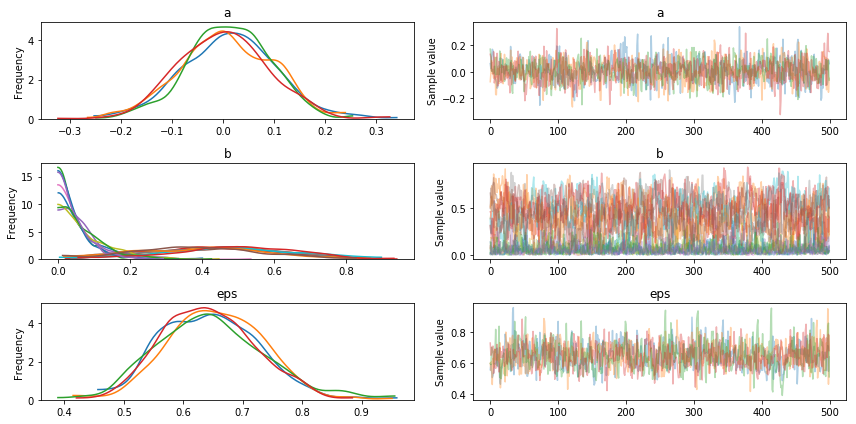

In [141]:
pm.traceplot(t5, varnames=['a', 'b', 'eps']);

## Plot Weights

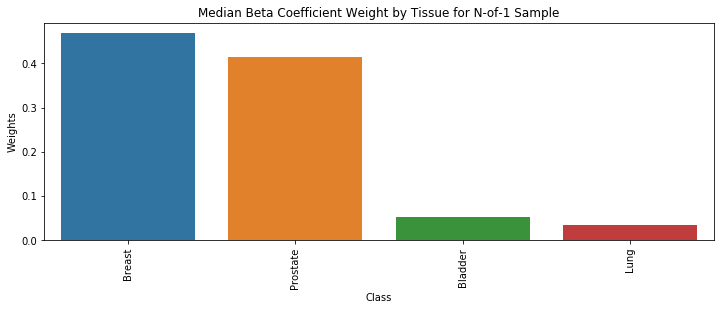

In [142]:
r.outlier.plot_weights(training_group.tissue.unique(), t5)

## PPC

In [158]:
ppc5 = r.outlier.ppc(t5, drug_genes)

## PPP

In [159]:
ppp5 = r.outlier.posterior_predictive_pvals(sample, ppc5)

## Pearson Correlation to Model with Thyroid

In [161]:
ppp = pd.DataFrame([ppp_drugs, ppp5]).T
ppp.columns = ['Thyroid', 'Thyroid-']

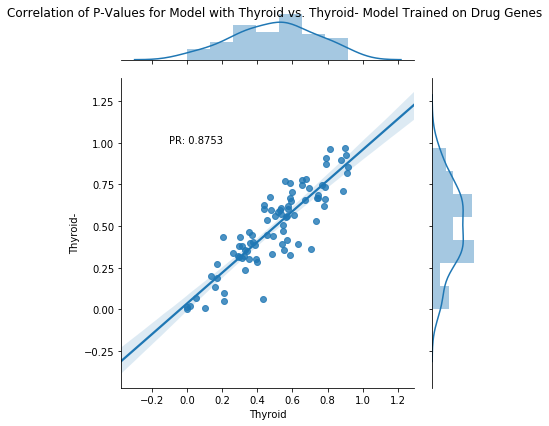

In [162]:
pr, pval = st.pearsonr(ppp.Thyroid, ppp['Thyroid-'])
sns.jointplot(data=ppp, x='Thyroid', y='Thyroid-', kind='reg')
plt.suptitle('Correlation of P-Values for Model with Thyroid vs. Thyroid- Model Trained on Drug Genes')
plt.text(-0.1, 1.0, f'PR: {round(pr, 4)}')
plt.tight_layout()

## Remove Breast and Rerun

In [166]:
training_group = training_group[training_group.tissue != 'Breast']

In [168]:
m6, t6 = r.outlier.run_model(sample, training_group, drug_genes, 'tissue')


Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Waiting for existing lock by process '21281' (I am process '17295')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '21281' (I am process '17295')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Prostate, PARP1-Lung, PARP1-Bladder, AURKC-Prostate, AURKC-Lung, AURKC-Bladder, AURKB-Prostate, AURKB-Lung, AURKB-Bladder, AURKA-Prostate, AURKA-Lung, AURKA-Bladder, MS4A1-Prostate, MS4A1-Lung, MS4A1-Bladder, BTK-Prostate, BTK-Lung, BTK-Bladder, HSP90B1-Prostate, HSP90B1-Lung, HSP90B1-Bladder, HSP90AB3P-Prostate, HSP90AB3P-Lung, HSP90AB3P-Bladder, HSP90AB1-Prostate, HSP90AB1-Lung, HSP90AB1-Bla

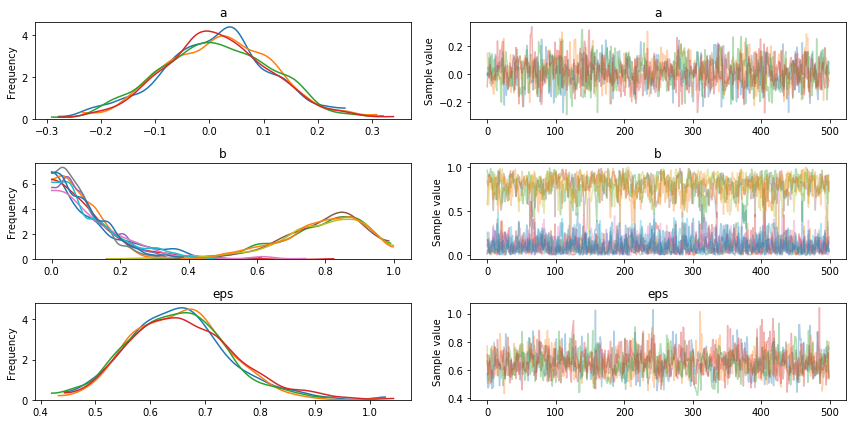

In [169]:
pm.traceplot(t6, varnames=['a', 'b', 'eps']);

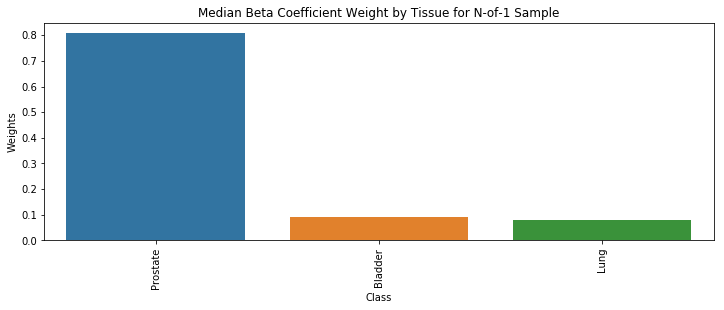

In [170]:
r.outlier.plot_weights(training_group.tissue.unique(), t6)

In [171]:
ppc6 = r.outlier.ppc(t6, drug_genes)

In [172]:
ppp6 = r.outlier.posterior_predictive_pvals(sample, ppc6)

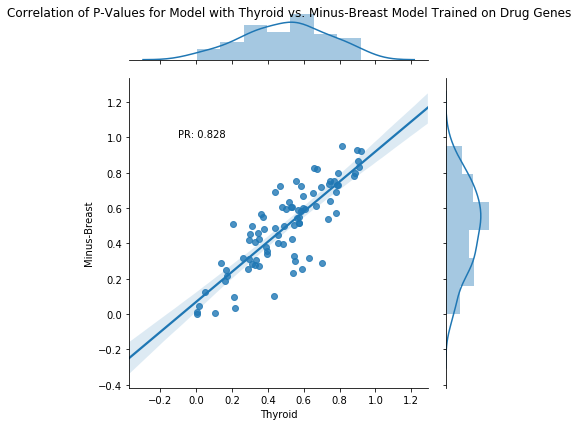

In [173]:
ppp = pd.DataFrame([ppp_drugs, ppp6]).T
ppp.columns = ['Thyroid', 'Minus-Breast']

pr, pval = st.pearsonr(ppp.Thyroid, ppp['Minus-Breast'])
sns.jointplot(data=ppp, x='Thyroid', y='Minus-Breast', kind='reg')
plt.suptitle('Correlation of P-Values for Model with Thyroid vs. Minus-Breast Model Trained on Drug Genes')
plt.text(-0.1, 1.0, f'PR: {round(pr, 4)}')
plt.tight_layout()

## Remove Prostate and Rerun

In [174]:
training_group = training_group[training_group.tissue != 'Prostate']

In [175]:
m7, t7 = r.outlier.run_model(sample, training_group, drug_genes, 'tissue')


Building model


INFO (theano.gof.compilelock): Waiting for existing lock by process '21281' (I am process '17295')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '21281' (I am process '17295')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


INFO (theano.gof.compilelock): Waiting for existing lock by process '21281' (I am process '17295')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '21281' (I am process '17295')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '21281' (I am process '17295')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '21281' (I am process '17295')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubunt

Sampling 4 chains: 100%|██████████| 4000/4000 [03:26<00:00,  7.83draws/s]


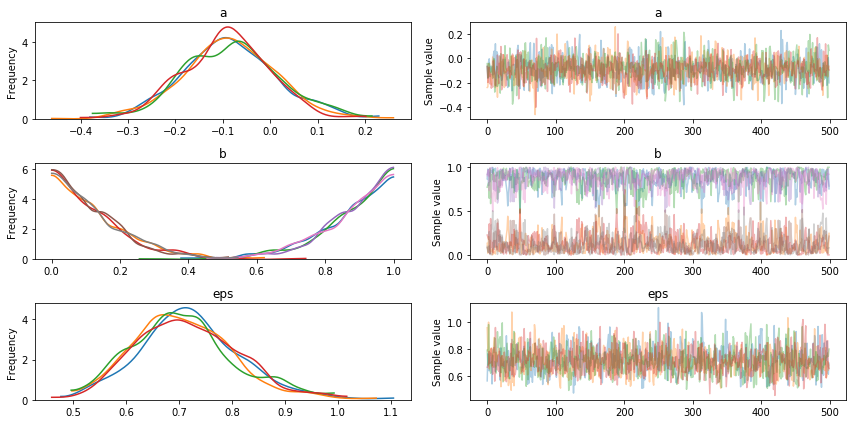

In [176]:
pm.traceplot(t7, varnames=['a', 'b', 'eps']);

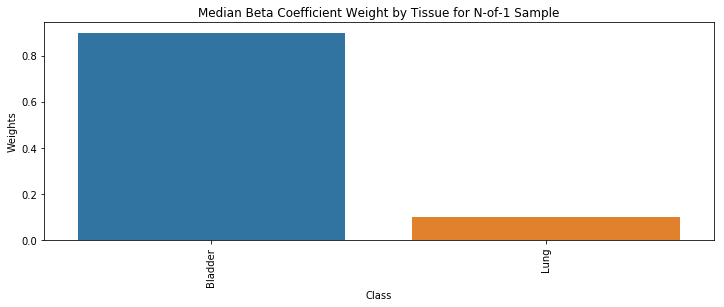

In [177]:
r.outlier.plot_weights(training_group.tissue.unique(), t7)

In [178]:
ppc7 = r.outlier.ppc(t7, drug_genes)

In [179]:
ppp7 = r.outlier.posterior_predictive_pvals(sample, ppc7)

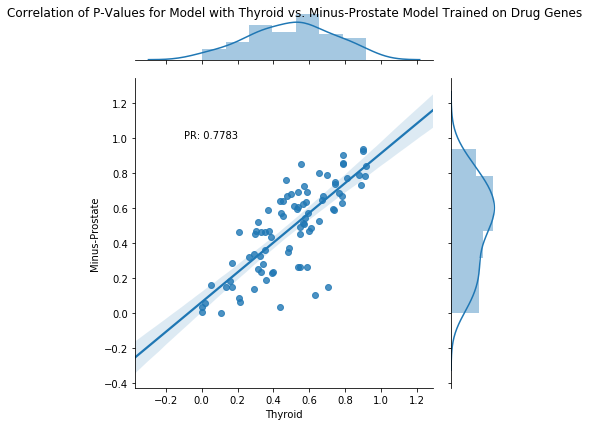

In [180]:
ppp = pd.DataFrame([ppp_drugs, ppp7]).T
ppp.columns = ['Thyroid', 'Minus-Prostate']

pr, pval = st.pearsonr(ppp.Thyroid, ppp['Minus-Prostate'])
sns.jointplot(data=ppp, x='Thyroid', y='Minus-Prostate', kind='reg')
plt.suptitle('Correlation of P-Values for Model with Thyroid vs. Minus-Prostate Model Trained on Drug Genes')
plt.text(-0.1, 1.0, f'PR: {round(pr, 4)}')
plt.tight_layout()

## Remove Bladder and Rerun

In [181]:
training_group = training_group[training_group.tissue != 'Bladder']

In [182]:
m8, t8 = r.outlier.run_model(sample, training_group, drug_genes, 'tissue')


Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PARP1-Lung, AURKC-Lung, AURKB-Lung, AURKA-Lung, MS4A1-Lung, BTK-Lung, HSP90B1-Lung, HSP90AB3P-Lung, HSP90AB1-Lung, HSP90AA1-Lung, MDM2-Lung, BCL6-Lung, BCL2-Lung, SMO-Lung, GLI1-Lung, PTCH1-Lung, MAP2K2-Lung, MAP2K1-Lung, ARAF-Lung, RAF1-Lung, BRAF-Lung, HRAS-Lung, KRAS-Lung, NRAS-Lung, DEPTOR-Lung, MLST8-Lung, RPTOR-Lung, MTOR-Lung, TSC2-Lung, TSC1-Lung, AKT3-Lung, AKT1-Lung, PIK3C3-Lung, PIK3C2G-Lung, PIK3C2B-Lung, PIK3C2A-Lung, PIK3R6-Lung, PIK3R5-Lung, PIK3R4-Lung, PIK3R3-Lung, PIK3R2-Lung, PIK3R1-Lung, PIK3CD-Lung, PIK3CG-Lung, PIK3CB-Lung, PIK3CA-Lung, CDK2-Lung, CCNE1-Lung, CCND3-Lung, CCND2-Lung, CCND1-Lung, CDK6-Lung, CDK4-Lung, TEK-Lung, CSF1R-Lung, KIT-Lung, KDR-Lung, FLT3-Lung, NTRK3-Lung, NTRK2-Lung, NTRK1-Lung, FGFR4-Lung, FGFR3-Lung, FGFR2-Lung, FGFR1-Lung, PDGFRB-Lung, PDGFRA-Lung, FLT4-Lung, FLT1-Lung, ROS1-Lung, MET-Lung, ALK-Lung, ERBB3-Lung, ERBB2-Lung, EGFR-Lung, IL6R-Lung, IL6-Lung, STAT5B-Lung, STAT5A-Lung, STAT3-

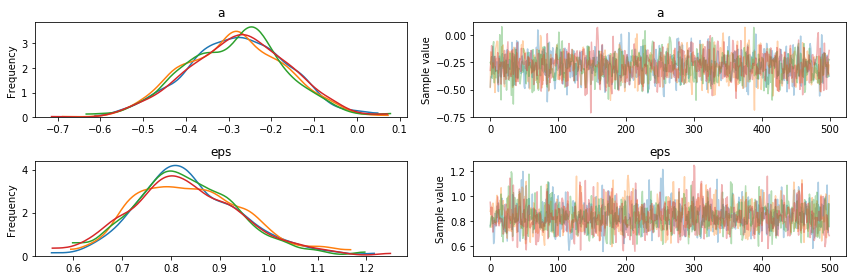

In [184]:
pm.traceplot(t8, varnames=['a', 'eps']);

In [192]:
ppc8 = {}
for gene in drug_genes:
    y_gene = [x for x in t8.varnames if x.startswith(f'{gene}-')]
    b = t8['a']
    for i, y_name in enumerate(y_gene):
        b += 1 * t8[y_name]
    ppc8[gene] = np.random.laplace(loc=b, scale=t8['eps'])

In [193]:
ppp8 = r.outlier.posterior_predictive_pvals(sample, ppc8)

In [226]:
a = pd.Series(ppp8)
a.to_csv('/mnt/testppp.tsv', sep='\t')

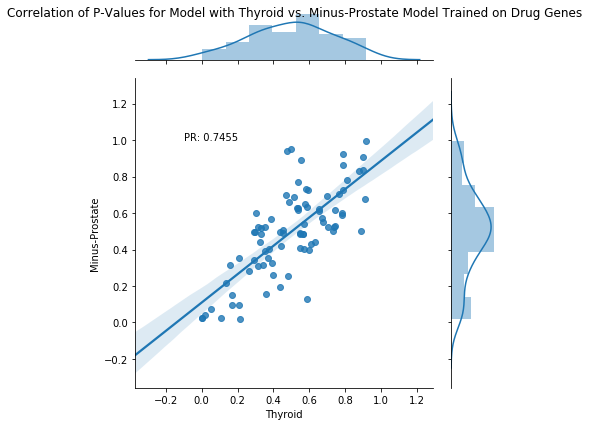

In [194]:
ppp = pd.DataFrame([ppp_drugs, ppp8]).T
ppp.columns = ['Thyroid', 'Minus-Prostate']

pr, pval = st.pearsonr(ppp.Thyroid, ppp['Minus-Prostate'])
sns.jointplot(data=ppp, x='Thyroid', y='Minus-Prostate', kind='reg')
plt.suptitle('Correlation of P-Values for Model with Thyroid vs. Minus-Prostate Model Trained on Drug Genes')
plt.text(-0.1, 1.0, f'PR: {round(pr, 4)}')
plt.tight_layout()

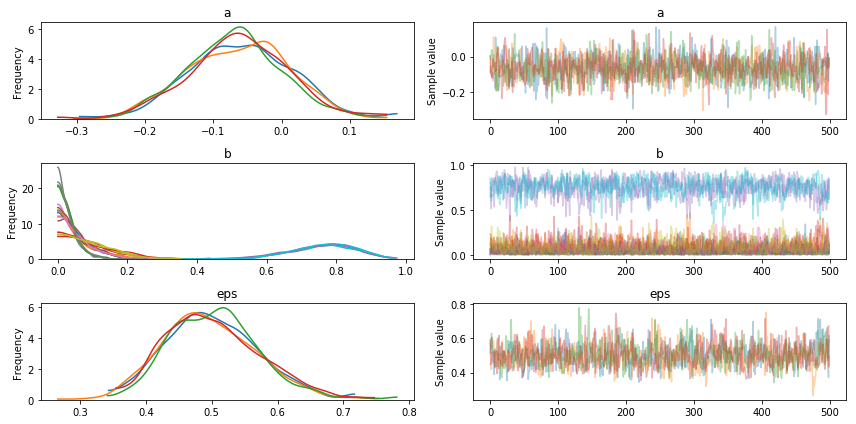

In [200]:
tp = pm.traceplot(t4, varnames=['a', 'b', 'eps'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe28f45fe80>,
      dtype=object)

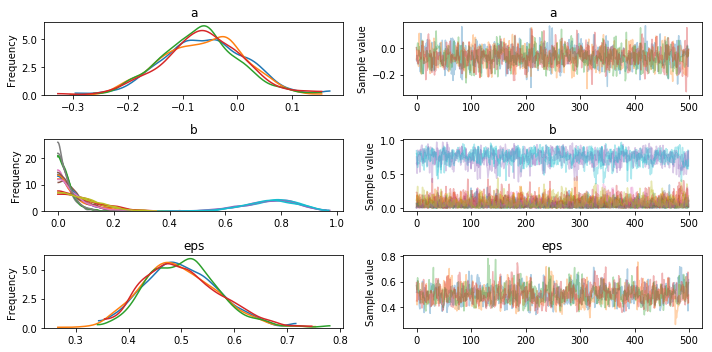

In [222]:
fig, axarr = plt.subplots(3, 2, figsize=(10, 5))
pm.traceplot(t4, varnames=['a', 'b', 'eps'], ax=axarr)

In [221]:
plt.savefig?